# Autoencoder Baseline for DCASE‑Inspired Anomalous Sound Detection


In [1]:
# Install dependencies (uncomment if needed)
# !pip install torch torchvision torchaudio librosa tqdm scikit-learn

In [2]:
import os, glob
import numpy as np
import torch
from torch import nn
import torchaudio
import torchaudio.transforms as T
import librosa, librosa.display
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import random

In [ ]:
# Device setup
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)
if DEVICE.type == 'cuda':
    print('GPU:', torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 4090


## DATA Examination

In [4]:
TRAIN_DIR = 'DATA/dev_data/dev_data/slider/train'
TEST_DIR = 'DATA/dev_data/dev_data/slider/test'
train_files = sorted(glob.glob(os.path.join(TRAIN_DIR, '*.wav')))
test_files  = sorted(glob.glob(os.path.join(TEST_DIR,  '*.wav')))
print('Train samples:', len(train_files))
print('Test  samples:', len(test_files))
print('First 3 train files:', train_files[:3])

def get_duration(path):
    return librosa.get_duration(path=path)
total_sec = sum(get_duration(f) for f in tqdm(train_files, desc='calc duration'))
print(f"Total train duration: {total_sec/3600:.2f} h")

Train samples: 2370
Test  samples: 1101
First 3 train files: ['DATA/dev_data/dev_data/slider/train\\normal_id_00_00000000.wav', 'DATA/dev_data/dev_data/slider/train\\normal_id_00_00000001.wav', 'DATA/dev_data/dev_data/slider/train\\normal_id_00_00000002.wav']


calc duration: 100%|██████████| 2370/2370 [00:01<00:00, 1547.92it/s]

Total train duration: 6.58 h


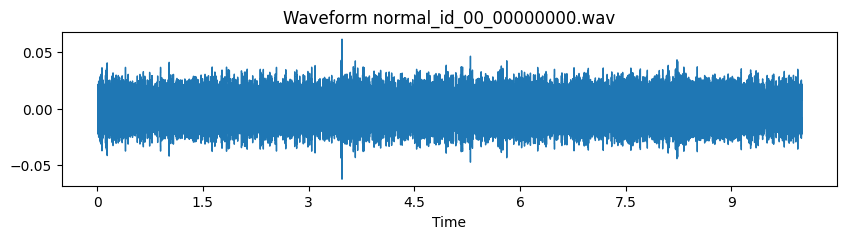

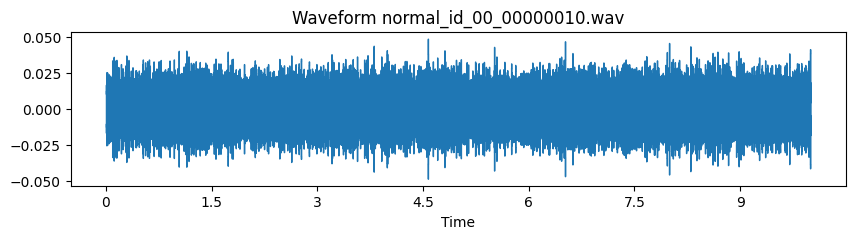

In [5]:
# Plot waveform examples
for idx in [0, 10]:
    y, sr = librosa.load(train_files[idx], sr=None)
    plt.figure(figsize=(10,2))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform {os.path.basename(train_files[idx])}")
    plt.show()

## Audio → log‑mel conversion

In [6]:
SAMPLE_RATE = 16000
N_MELS = 64
HOP = 512
FRAMES = 128

def audio_to_logmel(path, sr=SAMPLE_RATE):
    y, _ = librosa.load(path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, hop_length=HOP)
    logmel = librosa.power_to_db(mel)

    # Frame-wise pad/trim
    logmel = logmel.T  # [Time, Mel]
    if logmel.shape[0] < FRAMES:
        pad = FRAMES - logmel.shape[0]
        logmel = np.pad(logmel, ((0, pad), (0, 0)))
    else:
        logmel = logmel[:FRAMES]

    # Normalize
    logmel = (logmel - logmel.min()) / (logmel.max() - logmel.min() + 1e-6)
    return logmel



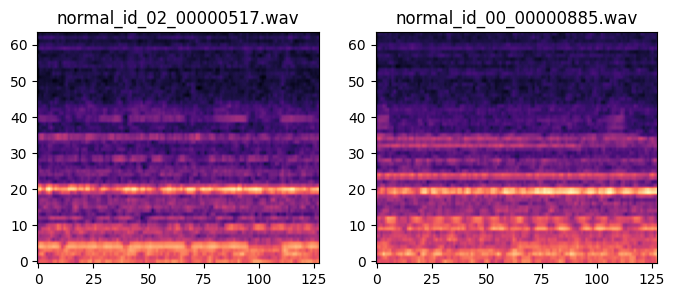

In [7]:
# Show spectrograms of random samples
fig, axes = plt.subplots(1,2, figsize=(8,3))
for ax, p in zip(axes, random.sample(train_files, 2)):
    lm = audio_to_logmel(p)
    ax.imshow(lm.T, origin='lower', aspect='auto', cmap='magma')
    ax.set_title(os.path.basename(p))
plt.show()

## Offline preprocess to `.npy`

In [8]:
PREP_DIR = 'DATA/preprocessed'
RAW_DIR = 'DATA/dev_data/dev_data/slider'

os.makedirs(f'{PREP_DIR}/train', exist_ok=True)
os.makedirs(f'{PREP_DIR}/test',  exist_ok=True)

for split in ['train','test']:
    src = os.path.join(RAW_DIR, split)
    dst = os.path.join(PREP_DIR, split)
    for wav in tqdm(glob.glob(f'{src}/*.wav'), desc=f'Prep {split}', leave=False):
        out_npy = os.path.join(dst, os.path.basename(wav).replace('.wav','.npy'))
        if os.path.exists(out_npy):
            continue
        np.save(out_npy, audio_to_logmel(wav))


## Dataset & DataLoader

In [9]:
class NPYSoundDataset(Dataset):
    def __init__(self, folder):
        self.files = sorted(glob.glob(os.path.join(folder, '*.npy')))
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        arr = np.load(self.files[idx])  # [frames, mels]
        x = torch.tensor(arr, dtype=torch.float32).flatten()
        label = 0 if 'normal' in self.files[idx].lower() else 1
        return x, label

BATCH_SIZE = 2048
train_ds = NPYSoundDataset(f'{PREP_DIR}/train')
test_ds  = NPYSoundDataset(f'{PREP_DIR}/test')
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

## Fully‑connected Autoencoder

In [10]:
INPUT_DIM = FRAMES * N_MELS
HIDDEN = 1024

class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(INPUT_DIM, HIDDEN), nn.ReLU())
        self.dec = nn.Sequential(nn.Linear(HIDDEN, INPUT_DIM), nn.ReLU())
    def forward(self, x): return self.dec(self.enc(x))

model = AE().to(DEVICE)
print(model)

AE(
  (enc): Sequential(
    (0): Linear(in_features=8192, out_features=1024, bias=True)
    (1): ReLU()
  )
  (dec): Sequential(
    (0): Linear(in_features=1024, out_features=8192, bias=True)
    (1): ReLU()
  )
)


## Training Loop

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.MSELoss()
EPOCHS = 500
history = []

for ep in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for x, _ in tqdm(train_dl, desc=f'Epoch {ep}/{EPOCHS}', leave=False):
        x = x.to(DEVICE)
        opt.zero_grad()
        out = model(x)
        loss = crit(out, x)
        loss.backward()
        opt.step()
        total_loss += loss.item() * x.size(0)
    avg = total_loss/len(train_ds)
    history.append(avg)
    print(f'Epoch {ep:2d} loss={avg:.4f}')


Epoch  1 loss=1.1502


Epoch  2 loss=0.2050


Epoch  3 loss=0.2392


Epoch  4 loss=0.1980


Epoch  5 loss=0.1771


Epoch  6 loss=0.1764


Epoch  7 loss=0.1676


Epoch  8 loss=0.1526


Epoch  9 loss=0.1431


Epoch 10 loss=0.1388


Epoch 11 loss=0.1355


Epoch 12 loss=0.1332


Epoch 13 loss=0.1326


Epoch 14 loss=0.1316


Epoch 15 loss=0.1297


Epoch 16 loss=0.1289


Epoch 17 loss=0.1288


Epoch 18 loss=0.1280


Epoch 19 loss=0.1268


Epoch 20 loss=0.1264


Epoch 21 loss=0.1262


Epoch 22 loss=0.1258


Epoch 23 loss=0.1254


Epoch 24 loss=0.1253


Epoch 25 loss=0.1251


Epoch 26 loss=0.1250


Epoch 27 loss=0.1250


Epoch 28 loss=0.1248


Epoch 29 loss=0.1248


Epoch 30 loss=0.1248


Epoch 31 loss=0.1247


Epoch 32 loss=0.1246


Epoch 33 loss=0.1246


Epoch 34 loss=0.1246


Epoch 35 loss=0.1245


Epoch 36 loss=0.1245


Epoch 37 loss=0.1245


Epoch 38 loss=0.1245


Epoch 39 loss=0.1245


Epoch 40 loss=0.1245


Epoch 41 loss=0.1245


Epoch 42 loss=0.1245


Epoch 43 loss=0.1245


Epoch 44 loss=0.1245


Epoch 45 loss=0.1244


Epoch 46 loss=0.1244


Epoch 47 loss=0.1244


Epoch 48 loss=0.1244


Epoch 49 loss=0.1244


Epoch 50 loss=0.1244


Epoch 51 loss=0.1244


Epoch 52 loss=0.1244


Epoch 53 loss=0.1244


Epoch 54 loss=0.1244


Epoch 55 loss=0.1244


Epoch 56 loss=0.1244


Epoch 57 loss=0.1244


Epoch 58 loss=0.1244


Epoch 59 loss=0.1244


Epoch 60 loss=0.1244


Epoch 61 loss=0.1244


Epoch 62 loss=0.1244


Epoch 63 loss=0.1244


Epoch 64 loss=0.1244


Epoch 65 loss=0.1244


Epoch 66 loss=0.1244


Epoch 67 loss=0.1244


Epoch 68 loss=0.1244


Epoch 69 loss=0.1244


Epoch 70 loss=0.1244


Epoch 71 loss=0.1244


Epoch 72 loss=0.1244


Epoch 73 loss=0.1244


Epoch 74 loss=0.1244


Epoch 75 loss=0.1244


Epoch 76 loss=0.1244


Epoch 77 loss=0.1244


Epoch 78 loss=0.1244


Epoch 79 loss=0.1244


Epoch 80 loss=0.1244


Epoch 81 loss=0.1244


Epoch 82 loss=0.1244


Epoch 83 loss=0.1244


Epoch 84 loss=0.1244


Epoch 85 loss=0.1244


Epoch 86 loss=0.1244


Epoch 87 loss=0.1244


Epoch 88 loss=0.1244


Epoch 89 loss=0.1244


Epoch 90 loss=0.1244


Epoch 91 loss=0.1244


Epoch 92 loss=0.1244


Epoch 93 loss=0.1244


Epoch 94 loss=0.1244


Epoch 95 loss=0.1244


Epoch 96 loss=0.1244


Epoch 97 loss=0.1244


Epoch 98 loss=0.1244


Epoch 99 loss=0.1244


Epoch 100 loss=0.1244


Epoch 101 loss=0.1244


Epoch 102 loss=0.1244


Epoch 103 loss=0.1243


Epoch 104 loss=0.1243


Epoch 105 loss=0.1243


Epoch 106 loss=0.1243


Epoch 107 loss=0.1243


Epoch 108 loss=0.1243


Epoch 109 loss=0.1243


Epoch 110 loss=0.1243


Epoch 111 loss=0.1243


Epoch 112 loss=0.1243


Epoch 113 loss=0.1243


Epoch 114 loss=0.1243


Epoch 115 loss=0.1243


Epoch 116 loss=0.1243


Epoch 117 loss=0.1243


Epoch 118 loss=0.1243


Epoch 119 loss=0.1243


Epoch 120 loss=0.1243


Epoch 121 loss=0.1242


Epoch 122 loss=0.1242


Epoch 123 loss=0.1242


Epoch 124 loss=0.1242


Epoch 125 loss=0.1242


Epoch 126 loss=0.1242


Epoch 127 loss=0.1241


Epoch 128 loss=0.1241


Epoch 129 loss=0.1240


Epoch 130 loss=0.1240


Epoch 131 loss=0.1240


Epoch 132 loss=0.1239


Epoch 133 loss=0.1239


Epoch 134 loss=0.1239


Epoch 135 loss=0.1239


Epoch 136 loss=0.1239


Epoch 137 loss=0.1239


Epoch 138 loss=0.1239


Epoch 139 loss=0.1238


Epoch 140 loss=0.1238


Epoch 141 loss=0.1237


Epoch 142 loss=0.1236


Epoch 143 loss=0.1236


Epoch 144 loss=0.1236


Epoch 145 loss=0.1236


Epoch 146 loss=0.1235


Epoch 147 loss=0.1235


Epoch 148 loss=0.1234


Epoch 149 loss=0.1234


Epoch 150 loss=0.1233


Epoch 151 loss=0.1233


Epoch 152 loss=0.1232


Epoch 153 loss=0.1231


Epoch 154 loss=0.1230


Epoch 155 loss=0.1229


Epoch 156 loss=0.1229


Epoch 157 loss=0.1228


Epoch 158 loss=0.1228


Epoch 159 loss=0.1228


Epoch 160 loss=0.1227


Epoch 161 loss=0.1226


Epoch 162 loss=0.1225


Epoch 163 loss=0.1223


Epoch 164 loss=0.1222


Epoch 165 loss=0.1222


Epoch 166 loss=0.1221


Epoch 167 loss=0.1221


Epoch 168 loss=0.1220


Epoch 169 loss=0.1219


Epoch 170 loss=0.1218


Epoch 171 loss=0.1216


Epoch 172 loss=0.1215


Epoch 173 loss=0.1213


Epoch 174 loss=0.1212


Epoch 175 loss=0.1211


Epoch 176 loss=0.1210


Epoch 177 loss=0.1209


Epoch 178 loss=0.1209


Epoch 179 loss=0.1208


Epoch 180 loss=0.1206


Epoch 181 loss=0.1205


Epoch 182 loss=0.1204


Epoch 183 loss=0.1203


Epoch 184 loss=0.1202


Epoch 185 loss=0.1200


Epoch 186 loss=0.1199


Epoch 187 loss=0.1197


Epoch 188 loss=0.1196


Epoch 189 loss=0.1194


Epoch 190 loss=0.1193


Epoch 191 loss=0.1191


Epoch 192 loss=0.1190


Epoch 193 loss=0.1189


Epoch 194 loss=0.1188


Epoch 195 loss=0.1187


Epoch 196 loss=0.1186


Epoch 197 loss=0.1185


Epoch 198 loss=0.1184


Epoch 199 loss=0.1183


Epoch 200 loss=0.1181


Epoch 201 loss=0.1180


Epoch 202 loss=0.1179


Epoch 203 loss=0.1178


Epoch 204 loss=0.1178


Epoch 205 loss=0.1177


Epoch 206 loss=0.1177


Epoch 207 loss=0.1176


Epoch 208 loss=0.1175


Epoch 209 loss=0.1174


Epoch 210 loss=0.1174


Epoch 211 loss=0.1173


Epoch 212 loss=0.1172


Epoch 213 loss=0.1172


Epoch 214 loss=0.1171


Epoch 215 loss=0.1170


Epoch 216 loss=0.1168


Epoch 217 loss=0.1168


Epoch 218 loss=0.1167


Epoch 219 loss=0.1166


Epoch 220 loss=0.1166


Epoch 221 loss=0.1165


Epoch 222 loss=0.1164


Epoch 223 loss=0.1164


Epoch 224 loss=0.1162


Epoch 225 loss=0.1161


Epoch 226 loss=0.1161


Epoch 227 loss=0.1160


Epoch 228 loss=0.1160


Epoch 229 loss=0.1159


Epoch 230 loss=0.1159


Epoch 231 loss=0.1158


Epoch 232 loss=0.1158


Epoch 233 loss=0.1157


Epoch 234 loss=0.1157


Epoch 235 loss=0.1157


Epoch 236 loss=0.1156


Epoch 237 loss=0.1156


Epoch 238 loss=0.1155


Epoch 239 loss=0.1155


Epoch 240 loss=0.1154


Epoch 241 loss=0.1153


Epoch 242 loss=0.1153


Epoch 243 loss=0.1152


Epoch 244 loss=0.1152


Epoch 245 loss=0.1151


Epoch 246 loss=0.1151


Epoch 247 loss=0.1151


Epoch 248 loss=0.1150


Epoch 249 loss=0.1150


Epoch 250 loss=0.1149


Epoch 251 loss=0.1149


Epoch 252 loss=0.1149


Epoch 253 loss=0.1148


Epoch 254 loss=0.1148


Epoch 255 loss=0.1148


Epoch 256 loss=0.1147


Epoch 257 loss=0.1147


Epoch 258 loss=0.1147


Epoch 259 loss=0.1147


Epoch 260 loss=0.1146


Epoch 261 loss=0.1146


Epoch 262 loss=0.1145


Epoch 263 loss=0.1145


Epoch 264 loss=0.1144


Epoch 265 loss=0.1144


Epoch 266 loss=0.1143


Epoch 267 loss=0.1143


Epoch 268 loss=0.1143


Epoch 269 loss=0.1143


Epoch 270 loss=0.1142


Epoch 271 loss=0.1142


Epoch 272 loss=0.1142


Epoch 273 loss=0.1141


Epoch 274 loss=0.1141


Epoch 275 loss=0.1141


Epoch 276 loss=0.1141


Epoch 277 loss=0.1141


Epoch 278 loss=0.1141


Epoch 279 loss=0.1140


Epoch 280 loss=0.1140


Epoch 281 loss=0.1139


Epoch 282 loss=0.1139


Epoch 283 loss=0.1138


Epoch 284 loss=0.1138


Epoch 285 loss=0.1138


Epoch 286 loss=0.1138


Epoch 287 loss=0.1137


Epoch 288 loss=0.1137


Epoch 289 loss=0.1137


Epoch 290 loss=0.1137


Epoch 291 loss=0.1136


Epoch 292 loss=0.1136


Epoch 293 loss=0.1136


Epoch 294 loss=0.1136


Epoch 295 loss=0.1136


Epoch 296 loss=0.1135


Epoch 297 loss=0.1135


Epoch 298 loss=0.1135


Epoch 299 loss=0.1135


Epoch 300 loss=0.1135


Epoch 301 loss=0.1135


Epoch 302 loss=0.1134


Epoch 303 loss=0.1134


Epoch 304 loss=0.1134


Epoch 305 loss=0.1134


Epoch 306 loss=0.1133


Epoch 307 loss=0.1133


Epoch 308 loss=0.1134


Epoch 309 loss=0.1133


Epoch 310 loss=0.1133


Epoch 311 loss=0.1133


Epoch 312 loss=0.1132


Epoch 313 loss=0.1132


Epoch 314 loss=0.1132


Epoch 315 loss=0.1132


Epoch 316 loss=0.1132


Epoch 317 loss=0.1132


Epoch 318 loss=0.1132


Epoch 319 loss=0.1131


Epoch 320 loss=0.1131


Epoch 321 loss=0.1131


Epoch 322 loss=0.1131


Epoch 323 loss=0.1131


Epoch 324 loss=0.1131


Epoch 325 loss=0.1131


Epoch 326 loss=0.1130


Epoch 327 loss=0.1130


Epoch 328 loss=0.1130


Epoch 329 loss=0.1130


Epoch 330 loss=0.1130


Epoch 331 loss=0.1129


Epoch 332 loss=0.1129


Epoch 333 loss=0.1129


Epoch 334 loss=0.1129


Epoch 335 loss=0.1129


Epoch 336 loss=0.1129


Epoch 337 loss=0.1129


Epoch 338 loss=0.1129


Epoch 339 loss=0.1129


Epoch 340 loss=0.1129


Epoch 341 loss=0.1129


Epoch 342 loss=0.1129


Epoch 343 loss=0.1129


Epoch 344 loss=0.1129


Epoch 345 loss=0.1129


Epoch 346 loss=0.1129


Epoch 347 loss=0.1129


Epoch 348 loss=0.1129


Epoch 349 loss=0.1128


Epoch 350 loss=0.1128


Epoch 351 loss=0.1128


Epoch 352 loss=0.1128


Epoch 353 loss=0.1128


Epoch 354 loss=0.1127


Epoch 355 loss=0.1127


Epoch 356 loss=0.1127


Epoch 357 loss=0.1127


Epoch 358 loss=0.1127


Epoch 359 loss=0.1127


Epoch 360 loss=0.1127


Epoch 361 loss=0.1127


Epoch 362 loss=0.1127


Epoch 363 loss=0.1127


Epoch 364 loss=0.1127


Epoch 365 loss=0.1127


Epoch 366 loss=0.1127


Epoch 367 loss=0.1127


Epoch 368 loss=0.1127


Epoch 369 loss=0.1127


Epoch 370 loss=0.1127


Epoch 371 loss=0.1127


Epoch 372 loss=0.1126


Epoch 373 loss=0.1126


Epoch 374 loss=0.1126


Epoch 375 loss=0.1126


Epoch 376 loss=0.1126


Epoch 377 loss=0.1126


Epoch 378 loss=0.1126


Epoch 379 loss=0.1126


Epoch 380 loss=0.1126


Epoch 381 loss=0.1126


Epoch 382 loss=0.1126


Epoch 383 loss=0.1126


Epoch 384 loss=0.1126


Epoch 385 loss=0.1126


Epoch 386 loss=0.1126


Epoch 387 loss=0.1125


Epoch 388 loss=0.1125


Epoch 389 loss=0.1125


Epoch 390 loss=0.1125


Epoch 391 loss=0.1125


Epoch 392 loss=0.1125


Epoch 393 loss=0.1125


Epoch 394 loss=0.1125


Epoch 395 loss=0.1125


Epoch 396 loss=0.1125


Epoch 397 loss=0.1125


Epoch 398 loss=0.1125


Epoch 399 loss=0.1125


Epoch 400 loss=0.1125


Epoch 401 loss=0.1125


Epoch 402 loss=0.1125


Epoch 403 loss=0.1125


Epoch 404 loss=0.1125


Epoch 405 loss=0.1125


Epoch 406 loss=0.1125


Epoch 407 loss=0.1125


Epoch 408 loss=0.1125


Epoch 409 loss=0.1125


Epoch 410 loss=0.1125


Epoch 411 loss=0.1125


Epoch 412 loss=0.1125


Epoch 413 loss=0.1125


Epoch 414 loss=0.1125


Epoch 415 loss=0.1125


Epoch 416 loss=0.1125


Epoch 417 loss=0.1125


Epoch 418 loss=0.1125


Epoch 419 loss=0.1125


Epoch 420 loss=0.1125


Epoch 421 loss=0.1125


Epoch 422 loss=0.1125


Epoch 423 loss=0.1125


Epoch 424 loss=0.1125


Epoch 425 loss=0.1125


Epoch 426 loss=0.1125


Epoch 427 loss=0.1125


Epoch 428 loss=0.1125


Epoch 429 loss=0.1125


Epoch 430 loss=0.1125


Epoch 431 loss=0.1125


Epoch 432 loss=0.1125


Epoch 433 loss=0.1125


Epoch 434 loss=0.1125


Epoch 435 loss=0.1125


Epoch 436 loss=0.1125


Epoch 437 loss=0.1125


Epoch 438 loss=0.1125


Epoch 439 loss=0.1125


Epoch 440 loss=0.1125


Epoch 441 loss=0.1125


Epoch 442 loss=0.1125


Epoch 443 loss=0.1125


Epoch 444 loss=0.1125


Epoch 445 loss=0.1125


Epoch 446 loss=0.1125


Epoch 447 loss=0.1125


Epoch 448 loss=0.1125


Epoch 449 loss=0.1125


Epoch 450 loss=0.1125


Epoch 451 loss=0.1125


Epoch 452 loss=0.1125


Epoch 453 loss=0.1125


Epoch 454 loss=0.1125


Epoch 455 loss=0.1125


Epoch 456 loss=0.1125


Epoch 457 loss=0.1125


Epoch 458 loss=0.1125


Epoch 459 loss=0.1125


Epoch 460 loss=0.1125


Epoch 461 loss=0.1125


Epoch 462 loss=0.1125


Epoch 463 loss=0.1124


Epoch 464 loss=0.1124


Epoch 465 loss=0.1124


Epoch 466 loss=0.1124


Epoch 467 loss=0.1124


Epoch 468 loss=0.1124


Epoch 469 loss=0.1124


Epoch 470 loss=0.1124


Epoch 471 loss=0.1124


Epoch 472 loss=0.1124


Epoch 473 loss=0.1124


Epoch 474 loss=0.1124


Epoch 475 loss=0.1124


Epoch 476 loss=0.1124


Epoch 477 loss=0.1124


Epoch 478 loss=0.1124


Epoch 479 loss=0.1124


Epoch 480 loss=0.1124


Epoch 481 loss=0.1124


Epoch 482 loss=0.1124


Epoch 483 loss=0.1124


Epoch 484 loss=0.1124


Epoch 485 loss=0.1124


Epoch 486 loss=0.1124


Epoch 487 loss=0.1124


Epoch 488 loss=0.1124


Epoch 489 loss=0.1124


Epoch 490 loss=0.1124


Epoch 491 loss=0.1124


Epoch 492 loss=0.1124


Epoch 493 loss=0.1124


Epoch 494 loss=0.1124


Epoch 495 loss=0.1124


Epoch 496 loss=0.1124


Epoch 497 loss=0.1124


Epoch 498 loss=0.1124


Epoch 499 loss=0.1124


Epoch 500 loss=0.1124


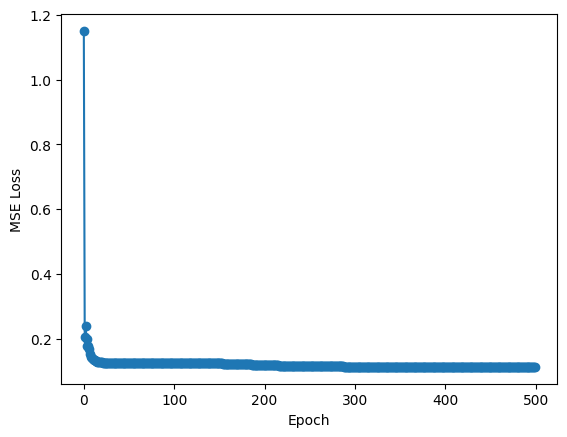

In [12]:
# Plot training loss
plt.figure()
plt.plot(history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

## Inference & AUC

In [13]:
model.eval()
scores, labels = [], []
with torch.no_grad():
    for x, y in tqdm(test_dl, desc='Testing', leave=False):
        x = x.to(DEVICE)
        err = ((x - model(x))**2).mean(dim=1).cpu().numpy()
        scores.extend(err)
        labels.extend(y.numpy())
auc = roc_auc_score(labels, scores)
print('AUC:', auc)


AUC: 0.6705826050769872


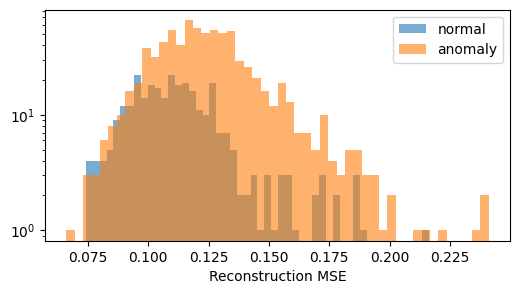

In [14]:
# Error distribution
normal_err = [s for s,l in zip(scores,labels) if l==0]
anom_err   = [s for s,l in zip(scores,labels) if l==1]
plt.figure(figsize=(6,3))
plt.hist(normal_err, bins=50, alpha=0.6, label='normal', log=True)
plt.hist(anom_err,   bins=50, alpha=0.6, label='anomaly', log=True)
plt.xlabel('Reconstruction MSE')
plt.legend()
plt.show()
